#1. Cloning the branch

In [1]:
!git clone https://github.com/vedpd/USD-MS-AAI.git
%cd USD-MS-AAI/Module\ 2
!git checkout module2-ved


Cloning into 'USD-MS-AAI'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 67 (delta 10), reused 48 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (67/67), 11.25 MiB | 16.25 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/USD-MS-AAI/Module 2
Branch 'module2-ved' set up to track remote branch 'module2-ved' from 'origin'.
Switched to a new branch 'module2-ved'


In [2]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 631.5 kB/s eta 0:00:00


#2. Library import

In [3]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, SpatialDropout1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import keras_tuner as kt
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import classification_report, f1_score
import keras_tuner as kt

#3. Data load

In [4]:
# Load your dataset
symptom_df2 = pd.read_csv("/content/USD-MS-AAI/Module 2/Data/Train_data.csv")

symptom_df2.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [5]:
symptom_df2.columns

Index(['Unnamed: 0', 'label', 'text'], dtype='object')

#3. Data Clean up

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text.strip()

In [7]:
# Apply cleaning - replace 'text_column' with the actual text feature name
symptom_df2['cleaned_text'] = symptom_df2['text'].apply(clean_text)

#4. Tokenization

In [8]:
# Tokenization
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(symptom_df2['cleaned_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [9]:
# Convert to sequences
max_len = 100
X = tokenizer.texts_to_sequences(symptom_df2['cleaned_text'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

# Label encoding
y = symptom_df2['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
num_classes = y_onehot.shape[1]


#5. Train test split

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

# Save vocab_size and num_classes for later use
print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Sample encoded text: {X_train[0]}")
print(f"Encoded label: {y_train[0]}")

Vocabulary size: 1584
Number of classes: 24
Sample encoded text: [ 23  29  19 291   2 321  23 201 502 269  21 735 182   8 381  91  22   3
  93   2  79   4   7  68   3  83   2  28  80 232 183   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Hybrid model

In [11]:
#Step 2: Build LSTM-GRU Hybrid Model
embedding_dim = 128

inputs = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)
x = SpatialDropout1D(0.3)(x)

# LSTM and GRU branches
lstm_out = LSTM(64, return_sequences=True)(x)
gru_out = GRU(64, return_sequences=True)(x)

# Concatenate both branches
x = Concatenate()([lstm_out, gru_out])
x = GlobalMaxPooling1D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │    202,752 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 100, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 64)   │     49,408 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 100, 64)   │     37,248 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 128)  │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ global_max_pooli… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24)        │      3,096 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 309,528 (1.18 MB)

 Trainable params: 309,272 (1.18 MB)

 Non-trainable params: 256 (1.00 KB)

#6. Model training

In [12]:
# Step 3: Training callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]


In [13]:
# Step 4: Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=15,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.0830 - loss: 3.1903

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.0838 - loss: 3.1869 - val_accuracy: 0.1042 - val_loss: 3.1613 - learning_rate: 0.0010
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3436 - loss: 2.6446

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.3461 - loss: 2.6385 - val_accuracy: 0.2500 - val_loss: 3.1017 - learning_rate: 0.0010
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6152 - loss: 1.7270

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.6161 - loss: 1.7218 - val_accuracy: 0.5417 - val_loss: 2.9594 - learning_rate: 0.0010
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7916 - loss: 1.0301

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7922 - loss: 1.0260 - val_accuracy: 0.6458 - val_loss: 2.7765 - learning_rate: 0.0010
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8845 - loss: 0.5503

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.8846 - loss: 0.5494 - val_accuracy: 0.8125 - val_loss: 2.5710 - learning_rate: 0.0010
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9349 - loss: 0.3532

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9353 - loss: 0.3520 - val_accuracy: 0.8542 - val_loss: 2.3569 - learning_rate: 0.0010
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9687 - loss: 0.2279

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9685 - loss: 0.2274 - val_accuracy: 0.8958 - val_loss: 2.1257 - learning_rate: 0.0010
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9813 - loss: 0.1615

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.9809 - loss: 0.1611 - val_accuracy: 0.9583 - val_loss: 1.8842 - learning_rate: 0.0010
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9911 - loss: 0.0934

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.9909 - loss: 0.0939 - val_accuracy: 0.9375 - val_loss: 1.6524 - learning_rate: 0.0010
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9815 - loss: 0.0992

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9816 - loss: 0.0990 - val_accuracy: 0.9792 - val_loss: 1.4206 - learning_rate: 0.0010
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9868 - loss: 0.0741

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9868 - loss: 0.0739 - val_accuracy: 0.9583 - val_loss: 1.1827 - learning_rate: 0.0010
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9967 - loss: 0.0460

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9967 - loss: 0.0461 - val_accuracy: 0.9896 - val_loss: 0.9541 - learning_rate: 0.0010
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9960 - loss: 0.0421

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9960 - loss: 0.0421 - val_accuracy: 0.9688 - val_loss: 0.7607 - learning_rate: 0.0010
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9849 - loss: 0.0563

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9850 - loss: 0.0562 - val_accuracy: 0.9792 - val_loss: 0.5831 - learning_rate: 0.0010
Epoch 15/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9906 - loss: 0.0389

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9905 - loss: 0.0390 - val_accuracy: 0.9896 - val_loss: 0.4346 - learning_rate: 0.0010


#7. Model Evaluation

In [14]:
# Step 5: Evaluate model
y_pred = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step

Classification Report:

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       1.00      0.80      0.89        10
                    Common Cold       1.00      1.00      1.00        10
                         Dengue       0.83      1.00      0.91        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       1.00      1.00      1.00        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      1.00      1.00        10
                       Jaundice       1.00      1.00      1.

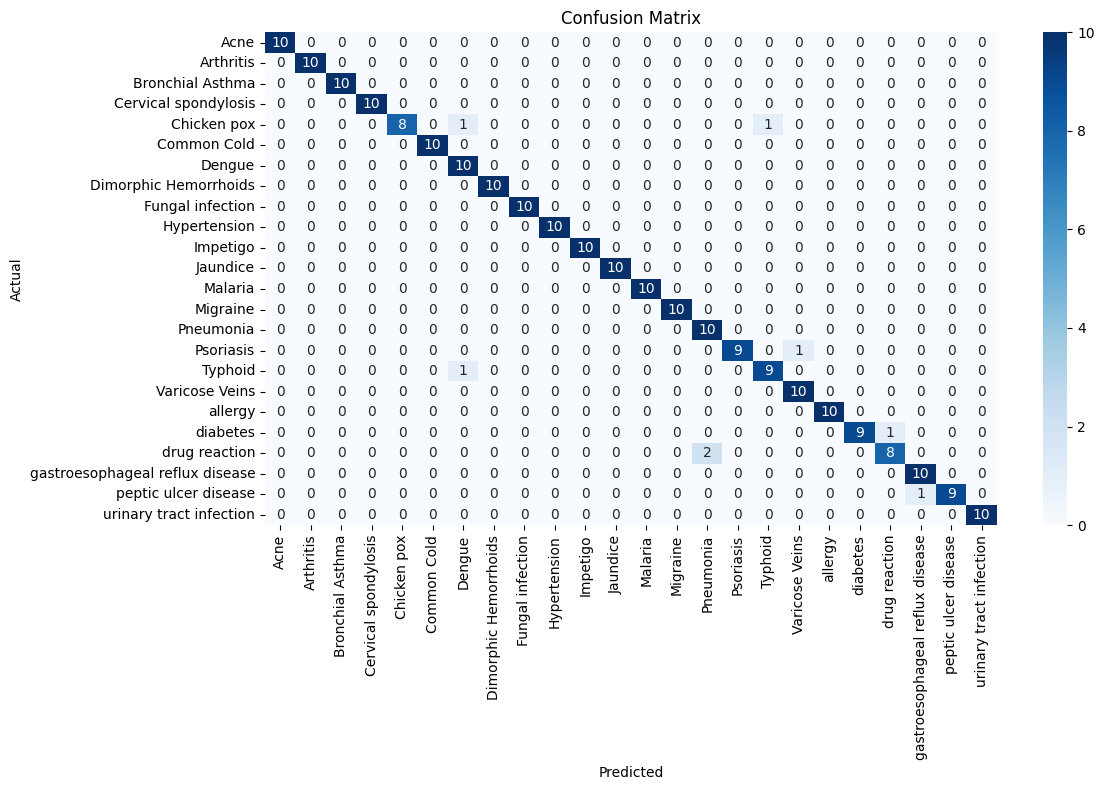

In [15]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [16]:
# Macro F1 Score
from sklearn.metrics import f1_score, confusion_matrix

f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro')
print(f"\nMacro F1 Score: {f1_macro:.4f}")


Macro F1 Score: 0.9665


# 8. Model saving

In [ ]:
# Save final model in .h5 format
model.save("final_symptom_classifier.h5")


In [ ]:
# After training
model.save("final_symptom_classifier.keras", save_format="keras")


In [ ]:
import pickle

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [ ]:
!pip freeze > requirements.txt


In [ ]:

import pickle

# Get label names from label encoder
label_names = list(label_encoder.classes_)

# Create label map dictionary
label_map = {label: idx for idx, label in enumerate(label_names)}

# Save to pickle
with open("label_map.pkl", "wb") as f:
    pickle.dump(label_map, f)

print("label_map.pkl saved.")


In [ ]:
# Save tokenizer
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(tokenizer_json)
